In [1]:
import grid2op
from grid2op.PlotGrid import PlotMatplot
from grid2op.Agent import BaseAgent
from grid2op.Runner import Runner
from grid2op.Agent import DoNothingAgent

In [2]:
env_name  = "educ_case14_storage"
env = grid2op.make(env_name, test=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/grid2op/MakeEnv/Make.py:305: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


In [3]:
env.gen_type, env.gen_renewable

(array(['nuclear', 'thermal', 'wind', 'solar', 'solar', 'hydro'],
       dtype='<U10'),
 array([False, False,  True,  True,  True, False]))

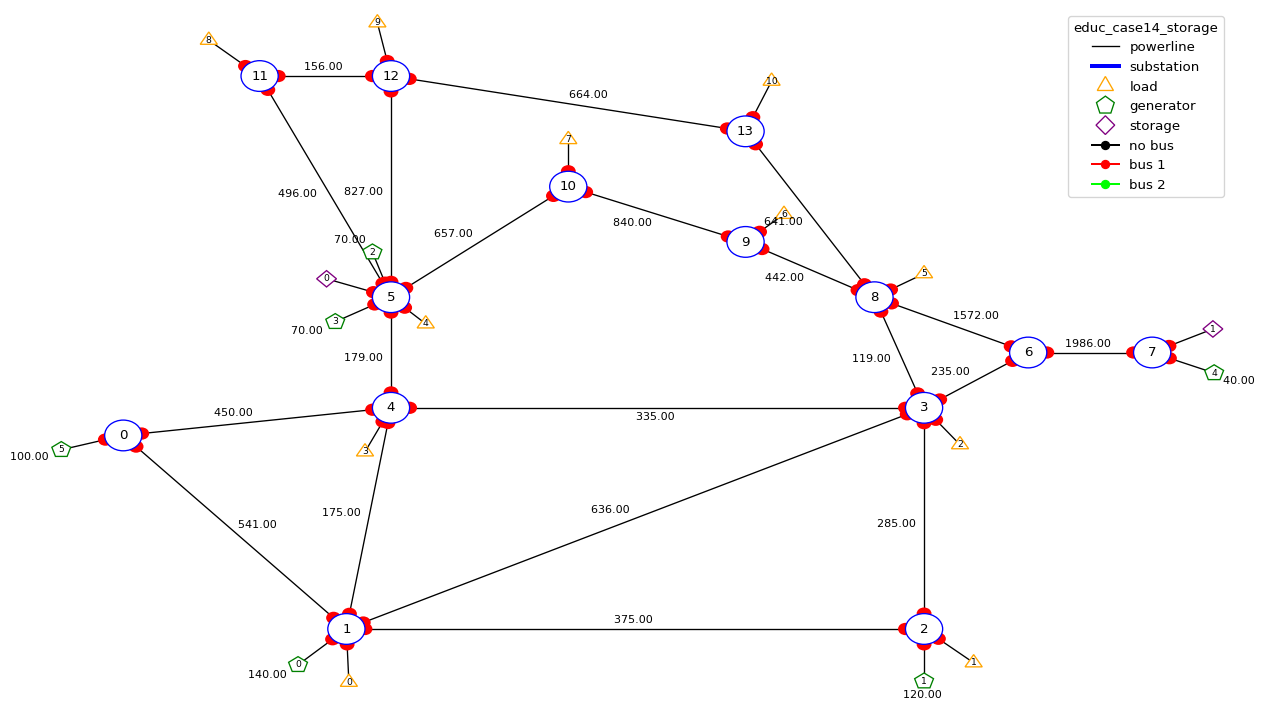

In [4]:
plot_helper = PlotMatplot(env.observation_space)
_ = plot_helper.plot_info(line_values=env._thermal_limit_a, gen_values=env.gen_pmax)

In [5]:
def test_agent(agent_class, agent_name, env, max_iter=10, nb_episode=1):
  runner = Runner(**env.get_params_for_runner(), agentClass=agent_class)
  res = runner.run(nb_episode=nb_episode, max_iter=max_iter)

  print(f"The results for the {agent_name} agent are:")
  for _, chron_name, cum_reward, nb_time_step, max_ts in res:
      msg_tmp = "\tFor chronics with id {}\n".format(chron_name)
      msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
      msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
      print(msg_tmp)

In [6]:
class ExpertAgent(BaseAgent):
  def __init__(self, action_space):
    # python required method to code
    BaseAgent.__init__(self, action_space)
    self.do_nothing = self.action_space({})
    self.print_next = True
        
  def act(self, observation, reward, done=False):
    _, reward_sim_dn, *_ = observation.simulate(self.do_nothing)
    return self.do_nothing

In [7]:
test_agent(ExpertAgent, "Expert", env)

The results for the Expert agent are:
	For chronics with id 2019-01-12
		 - cumulative reward: 139.106430
		 - number of time steps completed: 10 / 10


In [8]:
test_agent(DoNothingAgent, "DN", env)

The results for the DN agent are:
	For chronics with id 2019-01-12
		 - cumulative reward: 139.106430
		 - number of time steps completed: 10 / 10
